# Exploring curiosities about the Chilean electric grid

Data pulled from: https://www.coordinador.cl/operacion/graficos/desviacion-de-la-operacion-programada/desviacion-de-la-demanda-programada/

Note that where the forecasts originates is a third party provider (we believe) that is a box.

In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%matplotlib widget

In [2]:
pd.set_option("display.max_rows", 500)

This is system wide data pulled directly from CEN's website. I tried pulling many years of data, but only got (mostly) realiable data from 2021-2023. And a 6 month stint in 2020.

In [3]:
# filepath = "../data/datos-de-desviacion-de-la-demanda-sistemica-july-18-23.tsv"
filepath = "../data/datos-de-desviacion-de-la-demanda-sistemica-july-00-23.tsv"

df = pd.read_csv(filepath, delimiter="\t")

# Simple data cleaning
columns = ["real", "programado", "desviacion", "porcentaje"]
for column in columns:
    df[column] = df[column].str.replace(",", ".").astype(float)

df["datetime"] = pd.to_datetime(df["fecha"] + " " + (df["hora"] - 1).astype(str) + ":00:00")
# Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
df["weekday"] = df["datetime"].apply(lambda x: x.weekday())

In [4]:
print(df.shape)
df.head(10)

(18363, 8)


,fecha,hora,real,programado,desviacion,porcentaje,datetime,weekday
0,2020-04-27,1,8299.606301,8548.789733,249.183432,2.914839,2020-04-27 00:00:00,0
1,2020-04-27,2,7951.012882,7890.957875,-60.055007,-0.761061,2020-04-27 01:00:00,0
2,2020-04-27,3,7758.835658,7707.967261,-50.868397,-0.659946,2020-04-27 02:00:00,0
3,2020-04-27,4,7626.369477,7570.610207,-55.759270,-0.736523,2020-04-27 03:00:00,0
4,2020-04-27,5,7608.721015,7525.783706,-82.937309,-1.102042,2020-04-27 04:00:00,0
5,2020-04-27,6,7667.563026,7585.055886,-82.507140,-1.087759,2020-04-27 05:00:00,0
6,2020-04-27,7,7810.905978,7734.885522,-76.020457,-0.982826,2020-04-27 06:00:00,0
7,2020-04-27,8,7925.651138,8088.736258,163.085119,2.016200,2020-04-27 07:00:00,0
8,2020-04-27,9,8425.178090,8473.293207,48.115117,0.567844,2020-04-27 08:00:00,0
9,2020-04-27,10,9020.825941,8959.534990,-61.290951,-0.684086,2020-04-27 09:00:00,0


### Basic visualizations and metrics

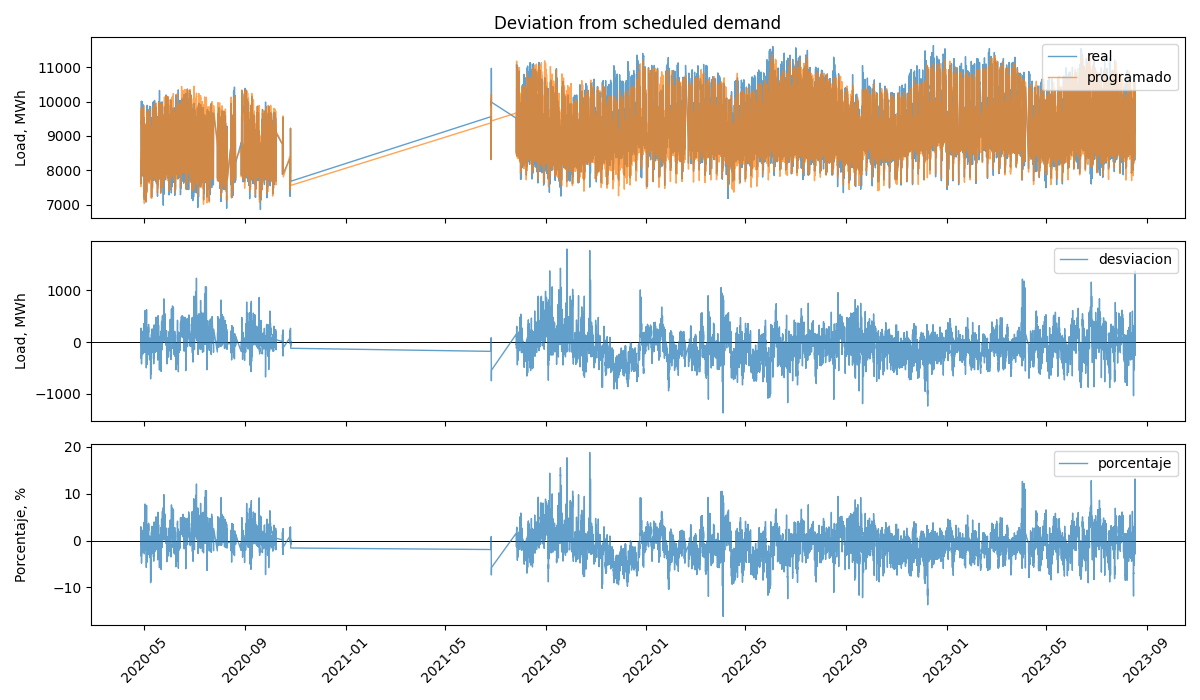

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
axs[0].plot("datetime", "real", data=df, lw=1, alpha=0.7, label="real")
axs[0].plot("datetime", "programado", data=df, lw=1, alpha=0.7, label="programado")
axs[0].set_title("Deviation from scheduled demand")
axs[0].set_ylabel("Load, MWh")

axs[1].plot("datetime", "desviacion", data=df, lw=1, alpha=0.7, label="desviacion")
axs[1].axhline(0, color="k", lw=0.7, zorder=-1)
axs[1].set_ylabel("Load, MWh")

axs[2].plot("datetime", "porcentaje", data=df, lw=1, alpha=0.7, label="porcentaje")
axs[2].axhline(0, color="k", lw=0.7, zorder=-1)
axs[2].set_ylabel("Porcentaje, %")

axs[2].tick_params(axis='x', labelrotation=45)
fig.align_ylabels()

for ax in axs:
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [6]:
# Dummy check CEN's error is correct.
# Error is predicted minus actual
print(np.allclose(df["programado"] - df["real"], df["desviacion"]))

# Percent error is predicted minus actual divided by predicted (rather than actual!), so it's not actually correct.
print(np.allclose((df["programado"] - df["real"]) / df["programado"] * 100, df["porcentaje"]))

True
True


In [7]:
# Basic metrics
mae = mean_absolute_error(df["real"], df["programado"])
mape = mean_absolute_percentage_error(df["real"], df["programado"]) * 100
mae, mape

(223.15720301274243, 2.380016464647236)

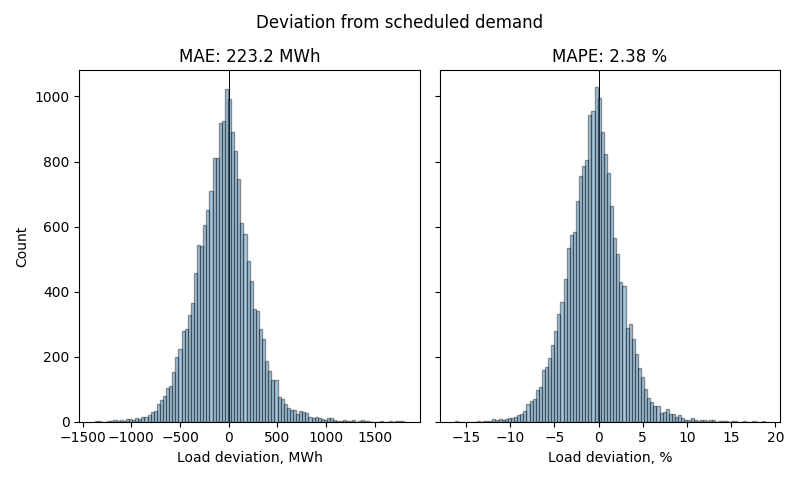

In [8]:
# Histogram of errors.
bins = 100
fig, axs = plt.subplots(1, 2, figsize=(8, 4.8), sharey=True)

axs[0].hist(df["desviacion"], bins=bins, edgecolor="black", alpha=0.4)
axs[0].set_xlabel("Load deviation, MWh")
axs[0].set_ylabel("Count")
axs[0].set_title(f"MAE: {mae:.1f} MWh")

axs[1].hist(df["porcentaje"], bins=bins, edgecolor="black", alpha=0.4)
axs[1].set_xlabel("Load deviation, %")
axs[1].set_title(f"MAPE: {mape:.2f} %")

for ax in axs:
    ax.axvline(0, color="black", lw=0.7, zorder=-1)
fig.suptitle("Deviation from scheduled demand", y=0.97)
plt.tight_layout()
plt.show()

Split apart the positive and negative errors. Metrics are similar, unsuprisingly since the errors are nearly zero centered. Could do a t-test on this.

In [9]:
df_pos = df.query("desviacion > 0") # prediction > actual
df_neg = df.query("desviacion < 0") # prediction < actual

pos_mape = mean_absolute_percentage_error(df_pos["real"], df_pos["programado"]) * 100
neg_mape = mean_absolute_percentage_error(df_neg["real"], df_neg["programado"]) * 100

pos_mae = mean_absolute_error(df_pos["real"], df_pos["programado"])
neg_mae = mean_absolute_error(df_neg["real"], df_neg["programado"])

pos_mape, neg_mape, pos_mae, neg_mae

(2.2957372088672154, 2.4406861621208, 206.06992039723693, 235.4577419452868)

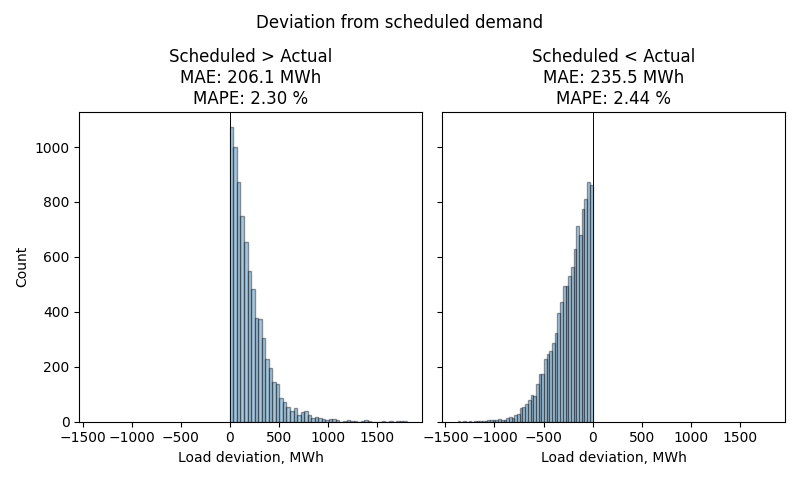

In [10]:
# Plot out the split apart errors
bins = 50
fig, axs = plt.subplots(1, 2, figsize=(8, 4.8), sharex=True, sharey=True)

axs[0].hist(df_pos["desviacion"], bins=bins, edgecolor="black", alpha=0.4)
axs[0].set_xlabel("Load deviation, MWh")
axs[0].set_ylabel("Count")
axs[0].set_title(f"Scheduled > Actual\nMAE: {pos_mae:.1f} MWh\nMAPE: {pos_mape:.2f} %")

axs[1].hist(df_neg["desviacion"], bins=bins, edgecolor="black", alpha=0.4)
axs[1].set_xlabel("Load deviation, MWh")
axs[1].set_title(f"Scheduled < Actual\nMAE: {neg_mae:.1f} MWh\nMAPE: {neg_mape:.2f} %")

for ax in axs:
    ax.axvline(0, color="black", lw=0.7, zorder=-1)

fig.suptitle("Deviation from scheduled demand", y=0.97)
plt.tight_layout()
plt.show()

Look at gaps in the data. I.e. how often are intervals between records >1 hour, indicating missing data.
- 6 intervals exceed the 100 hour threshold, including the big multi year/month ones
- 95% of intervals are 1 hour.
- Turns out there's a 4-5 gap in the data amost every day (starting around 8p-11p or 12a*) in the afteroon. 

\* eyeballed from a few examples. Follow up on this

In [11]:
time_deltas = df["datetime"].diff().apply(lambda x: x.total_seconds() / 3600)
percent_one_hour_intervals = time_deltas[(time_deltas > 0.990) & (time_deltas < 1.001)].shape[0] / time_deltas.shape[0] * 100
# percent_one_hour_intervals

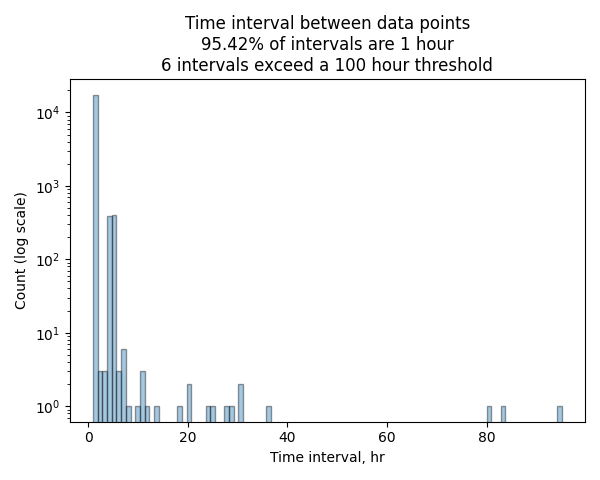

In [12]:
threshold = 100 # remove deltas exceeding threshold
n_exceeding = time_deltas[time_deltas >= threshold].shape[0]
fig, ax = plt.subplots(figsize=(6, 4.8))
ax.hist(time_deltas[time_deltas < threshold], log=True, bins=100, edgecolor="black", alpha=0.4)

ax.set_xlabel("Time interval, hr")
ax.set_ylabel("Count (log scale)")
ax.set_title(f"Time interval between data points\n{percent_one_hour_intervals:.2f}% of intervals are 1 hour\n{n_exceeding} intervals exceed a {threshold} hour threshold")
plt.tight_layout()
plt.show()

In [13]:
# Nearly every day, there is a 4-5 hour gap from about 8pm to 11p or 12a.
for i in range(1, 24):
    print(f"Interval (hrs): {i:2.0f} | Count: {np.sum(time_deltas == i)}")

Interval (hrs):  1 | Count: 17522
Interval (hrs):  2 | Count: 3
Interval (hrs):  3 | Count: 3
Interval (hrs):  4 | Count: 392
Interval (hrs):  5 | Count: 407
Interval (hrs):  6 | Count: 3
Interval (hrs):  7 | Count: 6
Interval (hrs):  8 | Count: 1
Interval (hrs):  9 | Count: 0
Interval (hrs): 10 | Count: 1
Interval (hrs): 11 | Count: 3
Interval (hrs): 12 | Count: 1
Interval (hrs): 13 | Count: 0
Interval (hrs): 14 | Count: 1
Interval (hrs): 15 | Count: 0
Interval (hrs): 16 | Count: 0
Interval (hrs): 17 | Count: 0
Interval (hrs): 18 | Count: 1
Interval (hrs): 19 | Count: 0
Interval (hrs): 20 | Count: 2
Interval (hrs): 21 | Count: 0
Interval (hrs): 22 | Count: 0
Interval (hrs): 23 | Count: 0


### Modeling

Start with the world's dumbest model: tomorrow's prediction is the average of the past n days.

Note that weekend demand is very different from weekday, so these are split apart into two "models".

Though likely overfitting to validation data, it seems 5 days for weekday and 2 days for weekend is optimal. To be clear, predicting a weekend involves skipping weekdays and vice versa, e.g. Sunday prediction = average (Saturday (yesterday), Sunday (last week)).

I also build a function to apply more weight to more recent days, but it doesn't seem to help.

In [14]:
# Cell does data clean up

# Use only data without large gaps.
df = df.query("datetime >= '2021-08-01' & datetime < '2023-08-01'").reset_index(drop=True)

# Use for testing only
# df = df.head(10)
# df = df.drop([1,2,4]).reset_index(drop=True)

# Add rows for missing hours
hourly_range = pd.date_range(start=df["datetime"].min(), end=df["datetime"].max(), freq='H')
df_dense = pd.DataFrame({'datetime': hourly_range})
df = pd.merge(df_dense, df, on="datetime", how="outer").sort_values(by="datetime").reset_index(drop=True)

# Impute with forward fill missing values
columns_to_fill = ["real", "programado", "desviacion", "porcentaje"]
for column in columns_to_fill:
    df[column].fillna(method="ffill", inplace=True)

# Update datetime related columns
df["weekday"] = df["datetime"].apply(lambda x: x.weekday())
df["hour"] = df["datetime"].apply(lambda x: x.hour)
df["date"] = df["datetime"].apply(lambda x: x.date())
df

,datetime,fecha,hora,real,programado,desviacion,porcentaje,weekday,hour,date
0,2021-08-01 00:00:00,2021-08-01,1.0,8996.207256,9011.737416,15.530160,0.172333,6,0,2021-08-01
1,2021-08-01 01:00:00,2021-08-01,2.0,8285.296170,8569.670961,284.374790,3.318386,6,1,2021-08-01
2,2021-08-01 02:00:00,2021-08-01,3.0,8163.861534,8184.699944,20.838410,0.254602,6,2,2021-08-01
3,2021-08-01 03:00:00,2021-08-01,4.0,7957.178548,7973.291399,16.112850,0.202085,6,3,2021-08-01
4,2021-08-01 04:00:00,2021-08-01,5.0,7827.956302,7917.363481,89.407179,1.129254,6,4,2021-08-01
...,...,...,...,...,...,...,...,...,...,...
17511,2023-07-31 15:00:00,2023-07-31,16.0,10067.300100,10304.862952,237.562853,2.305347,0,15,2023-07-31
17512,2023-07-31 16:00:00,2023-07-31,17.0,10111.177520,10251.489618,140.312098,1.368700,0,16,2023-07-31
17513,2023-07-31 17:00:00,2023-07-31,18.0,9931.279106,10117.394246,186.115140,1.839556,0,17,2023-07-31
17514,2023-07-31 18:00:00,2023-07-31,19.0,10117.323059,10467.922498,350.599439,3.349274,0,18,2023-07-31


Split the data.

In [15]:
num_train = int(0.5 * df.shape[0])
num_val = int(0.25 * df.shape[0])
num_train, num_val

df_train = df[:num_train].sort_values(by="datetime").reset_index(drop=True)
df_val = df[num_train: num_train + num_val].sort_values(by="datetime").reset_index(drop=True)
df_test = df[num_train + num_val:].sort_values(by="datetime").reset_index(drop=True)

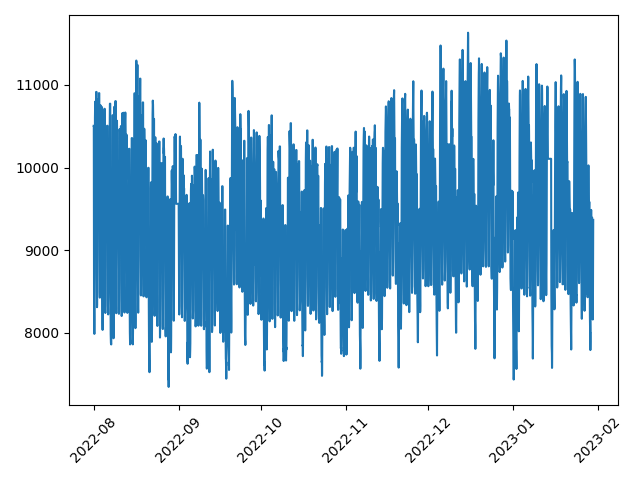

In [16]:
# Verify val data looks good.
_, ax = plt.subplots()
ax.plot("datetime", "real", "-", data=df_val)
ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

Step through the model day by day to make forecasts.

In [17]:
past_n_days_weekday = 5
past_n_days_weekend = 2

WEEKDAYS = [0, 1, 2, 3, 4]
WEEKENDS = [5, 6]


def get_data(date):
    weekday = date.weekday()
    if weekday in WEEKDAYS:
        past_n_days = past_n_days_weekday
        days = WEEKDAYS
    elif weekday in WEEKENDS:
        past_n_days = past_n_days_weekend
        days = WEEKENDS
    else:
        raise ValueError(f"Weekday must be an int between 0 and 6. Given: {weekday}")
    return past_n_days, days


def get_past_dates(date, past_n_days, days):
    past_dates = []
    candidate_date = date - timedelta(days=1)
    while len(past_dates) < past_n_days:
        if candidate_date.weekday() in days:
            past_dates.append(candidate_date)
        candidate_date -= timedelta(days=1)
    return past_dates

def get_daily_weights(past_n_days):
    weights = np.exp2([i for i in range(past_n_days)])
    return weights / np.sum(weights) # sum to 1

df_predictions_list = []
unique_dates = df_val["date"].unique()

count = 0 # remove
for date in unique_dates:
    past_n_days, days = get_data(date)
    past_dates = get_past_dates(date, past_n_days, days)

    df_input = df[df["date"].apply(lambda x: x in past_dates)].sort_values(by="datetime").reset_index(drop=True)
    df_output = df[df["date"] == date].sort_values(by="datetime").reset_index(drop=True)

    weights = get_daily_weights(past_n_days)
    baseline_predictions = df_input.groupby(by="hour")["real"].mean()

    weight_map = {date: weight for date, weight in zip(df_input["date"].unique(), weights)}
    df_input["real_weighted"] = df_input.apply(lambda x: x["real"] * weight_map[x["date"]], axis=1)
    baseline_prediction_weighted = df_input.groupby(by="hour")["real_weighted"].sum()

    df_sample = pd.DataFrame({"datetime": df_output["datetime"], "baseline_prediction": baseline_predictions, "baseline_prediction_weighted": baseline_prediction_weighted})
    df_predictions_list.append(df_sample)

    # if count == 1:
    #     print(date, date.weekday(), past_n_days, days)
    #     print(past_dates)
    #     print("\n")

    #     display(df_input)
    #     display(df_output)
    #     print(weights)
    #     break
    # count += 1 # remove

df_predictions = pd.concat(df_predictions_list)
df_val_with_predictions = pd.merge(df_val, df_predictions, on="datetime", how="outer").dropna(subset="real").sort_values(by="datetime").reset_index(drop=True)

In [18]:
mae = mean_absolute_error(df_val_with_predictions["real"], df_val_with_predictions["programado"])
mae_baseline = mean_absolute_error(df_val_with_predictions["real"], df_val_with_predictions["baseline_prediction"])
mae_baseline_weighted = mean_absolute_error(df_val_with_predictions["real"], df_val_with_predictions["baseline_prediction_weighted"])

mape = mean_absolute_percentage_error(df_val_with_predictions["real"], df_val_with_predictions["programado"]) * 100
mape_baseline = mean_absolute_percentage_error(df_val_with_predictions["real"], df_val_with_predictions["baseline_prediction"]) * 100
mape_baseline_weighted = mean_absolute_percentage_error(df_val_with_predictions["real"], df_val_with_predictions["baseline_prediction_weighted"]) * 100

print(f"CEN MAE:               {mae:.2f} MWh")
print(f"Baseline MAE:          {mae_baseline:.2f} MWh")
print(f"Weighted baseline MAE: {mae_baseline_weighted:.2f} MWh")

print(f"CEN MAPE:               {mape:.2f} %")
print(f"Baseline MAPE:          {mape_baseline:.2f} %")
print(f"Weighted baseline MAPE: {mape_baseline_weighted:.2f} %")

CEN MAE:               204.06 MWh
Baseline MAE:          279.56 MWh
Weighted baseline MAE: 296.56 MWh
CEN MAPE:               2.13 %
Baseline MAPE:          3.00 %
Weighted baseline MAPE: 3.21 %


Calculate errors to make some plots

In [19]:
# My percentage calc follows their convention of dividing by prediction, which is wrong but I'm trying to be consistent.
df_val_with_predictions["baseline_deviation"] = df_val_with_predictions.apply(lambda x: x["real"] - x["baseline_prediction"], axis=1)
df_val_with_predictions["baseline_percentage"] = df_val_with_predictions.apply(lambda x: x["baseline_deviation"] / x["baseline_prediction"] * 100, axis=1)

df_val_with_predictions["baseline_deviation_weighted"] = df_val_with_predictions.apply(lambda x: x["real"] - x["baseline_prediction_weighted"], axis=1)
df_val_with_predictions["baseline_percentage_weighted"] = df_val_with_predictions.apply(lambda x: x["baseline_deviation_weighted"] / x["baseline_prediction_weighted"] * 100, axis=1)

df_val_with_predictions.head()

,datetime,fecha,hora,real,programado,desviacion,porcentaje,weekday,hour,date,baseline_prediction,baseline_prediction_weighted,baseline_deviation,baseline_percentage,baseline_deviation_weighted,baseline_percentage_weighted
0,2022-07-31 22:00:00,NaN,NaN,10505.583633,10350.436553,-155.147081,-1.498942,6.0,22.0,2022-07-31,10575.020568,10574.765017,-69.436935,-0.656613,-69.181384,-0.654212
1,2022-07-31 23:00:00,NaN,NaN,10505.583633,10350.436553,-155.147081,-1.498942,6.0,23.0,2022-07-31,10575.020568,10574.765017,-69.436935,-0.656613,-69.181384,-0.654212
2,2022-08-01 00:00:00,2022-08-01,1.0,8925.647819,8823.398396,-102.249423,-1.158844,0.0,0.0,2022-08-01,9238.585236,9358.015145,-312.937417,-3.387287,-432.367326,-4.620289
3,2022-08-01 01:00:00,2022-08-01,2.0,8426.037365,8383.196434,-42.840931,-0.511033,0.0,1.0,2022-08-01,8771.199022,8891.597319,-345.161658,-3.935171,-465.559955,-5.235954
4,2022-08-01 02:00:00,2022-08-01,3.0,8151.792254,8087.887906,-63.904348,-0.790124,0.0,2.0,2022-08-01,8462.781053,8584.141338,-310.988799,-3.674783,-432.349084,-5.036603


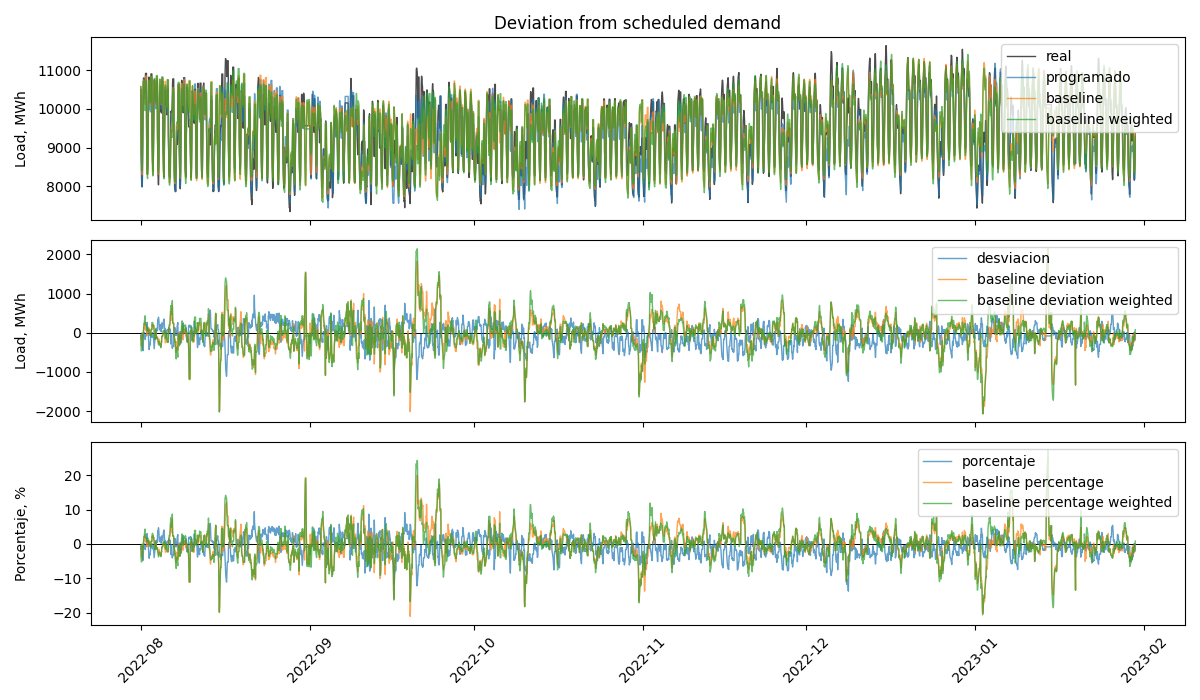

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
axs[0].plot("datetime", "real", data=df_val_with_predictions, lw=1, alpha=0.7, c="k", label="real")
axs[0].plot("datetime", "programado", data=df_val_with_predictions, lw=1, alpha=0.7, label="programado")
axs[0].plot("datetime", "baseline_prediction", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline")
axs[0].plot("datetime", "baseline_prediction_weighted", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline weighted")
axs[0].set_title("Deviation from scheduled demand")
axs[0].set_ylabel("Load, MWh")

axs[1].plot("datetime", "desviacion", data=df_val_with_predictions, lw=1, alpha=0.7, label="desviacion")
axs[1].plot("datetime", "baseline_deviation", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline deviation")
axs[1].plot("datetime", "baseline_deviation_weighted", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline deviation weighted")
axs[1].axhline(0, color="k", lw=0.7, zorder=-1)
axs[1].set_ylabel("Load, MWh")

axs[2].plot("datetime", "porcentaje", data=df_val_with_predictions, lw=1, alpha=0.7, label="porcentaje")
axs[2].plot("datetime", "baseline_percentage", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline percentage")
axs[2].plot("datetime", "baseline_percentage_weighted", data=df_val_with_predictions, lw=1, alpha=0.7, label="baseline percentage weighted")
axs[2].axhline(0, color="k", lw=0.7, zorder=-1)
axs[2].set_ylabel("Porcentaje, %")

axs[2].tick_params(axis='x', labelrotation=45)
fig.align_ylabels()

for ax in axs:
    ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Sarimax
kind of helpful:
https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

Doesn't work yet, but this is where we need to go.

In [21]:
# import statsmodels.api as sm

In [22]:
# model = sm.tsa.statespace.SARIMAX(
#     endog=df_train["real"],
#     order=(1, 1, 1),
#     seasonal_order=(1, 1, 1, 12),
# )
# results = model.fit()
# results

In [23]:
# import itertools
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [24]:
# # warnings.filterwarnings("ignore") 
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(endog=train.Rides,\
#                                             trend='n',\
#                                             order=(1,0,1),\
#                                             seasonal_order=(1,0,1,12))

#             results = mod.fit()

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [25]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(df_train["real"], model='additive', period = 100)
# fig = decomposition.plot()
# plt.show()

# df_train.head()

### Scraps

In [26]:
# df.loc[3, "datetime"]

In [27]:
# _, ax = plt.subplots()
# ax.plot("datetime", "real", data=df)
# ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()

In [28]:
# past_n_days = 5
# v = np.exp2([i for i in range(past_n_days)])
# v /= np.sum(v)
# v

In [29]:
# from enum import auto, Enum

# class DayType(Enum):
#     WEEKDAY = auto()
#     WEEKEND = auto()
#     UNKNONW = auto()

# def get_day_type(date) -> DayType:
#     weekday = date.weekday()
#     if weekday in WEEKDAYS:
#         day_type = DayType.WEEKDAY
#     elif weekday in WEEKENDS:
#         day_type = DayType.WEEKEND
#     else:
#         raise ValueError(f"Weekday must be an int between 0 and 6. Given: {weekday}")
#     return day_type

# day_type = DayType.WEEKDAY
# day_type

In [30]:
# # REMOVE ME!!!
# fig, axs = plt.subplots(figsize=(12, 3), sharex=True)
# axs.plot("datetime", "real", "o-", data=df_orig, lw=1, alpha=0.7, label="real orig")
# axs.plot("datetime", "real", "o-", data=df, lw=1, alpha=0.7, label="real")
# axs.legend()
# # axs.plot("datetime", "programado", data=df, lw=1, alpha=0.7, label="programado")
# axs.set_title("Deviation from scheduled demand")
# axs.set_ylabel("Load, MWh")
# plt.tight_layout()
# plt.show()